In [1]:
# ==========================================
# 1. 라이브러리 및 환경 설정
# ==========================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import joblib
import copy

# 실행할 때마다 같은 결과가 나오도록 시드(Seed)를 고정하기
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# ==========================================
# 2. 데이터 로드 및 전처리
# ==========================================

# 1) CSV 파일 불러오기
csv_filename = 'data/data.csv'
try:
    df = pd.read_csv(csv_filename)
    print(f"✅ 데이터 로드 성공!\nTotal Dataset: {df.shape[0]}개")
except FileNotFoundError:
    print(f"❌ 데이터 로드 실패! '{csv_filename}' 파일을 찾을 수 없습니다.")
    raise

# 2) 입력 변수 선택하기
# 원천 데이터는 제외하고, 파생 데이터 5개만 입력 변수로 사용합니다.
feature_cols = ['H_Ratio', '2B_3B_Ratio', 'HR_Ratio', 'SO_Ratio', 'BB_Ratio']
X = df[feature_cols].values

# 3) 라벨 인코딩
# GAP: 0, POWER: 1, CONTACT: 2
label_map = {'GAP': 0, 'POWER': 1, 'CONTACT': 2}
df['Batter_Type_Encoded'] = df['Batter_Type'].map(label_map)
y = df['Batter_Type_Encoded'].values

✅ 데이터 로드 성공!
Total Dataset: 195개


In [3]:
# ==========================================
# 3. 데이터 분할
# ==========================================

# Total Dataset의 20%인 39개를 Test Set으로 분리합니다.
# Test Set을 제외한 Total Dataset의 80%인 156개를 Train/Validation Set으로 사용합니다.
X_remain, X_test, y_remain, y_test = train_test_split(
    X, y, test_size=39, random_state=42, stratify=y
)

print(f"Train/Validation Set: {len(X_remain)}개")
print(f"Test Set: {len(X_test)}개")

# Train/Validation Set을 기준으로 스케일링을 수행합니다.
scaler = StandardScaler()
X_remain_scaled = scaler.fit_transform(X_remain)
X_test_scaled = scaler.transform(X_test)

# evaluation과 inference를 위해 스케일러와 Test Set을 저장합니다.
joblib.dump(scaler, 'scaler.pkl')
np.savez('eval_data.npz', X_test=X_test_scaled, y_test=y_test)

Train/Validation Set: 156개
Test Set: 39개


In [ ]:
# ==========================================
# 4. 데이터셋 및 모델 아키텍처 설계
# ==========================================

class BatterTypeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# MLP (Multi-Layer Perceptron)
class BatterTypeClassifier(nn.Module):
    def __init__(self):
        super(BatterTypeClassifier, self).__init__()

        # [Layer1]
        # 입력: 5개 (H_Ratio, 2B_3B_Ratio, HR_Ratio, SO_Ratio, BB_Ratio)
        # 출력: 64개
        self.layer1 = nn.Linear(5, 64)

        # Activation Function: ReLU
        self.relu = nn.ReLU()

        # [Dropout]
        # Dropout 비율: 30%
        self.dropout = nn.Dropout(0.3)

        # [Layer2]
        # 입력: 64개
        # 출력: 32개
        self.layer2 = nn.Linear(64, 32)

        # [Layer3 (Output Layer)]
        # 입력: 32개
        # 출력: 3 (GAP일 점수, POWER일 점수, CONTACT일 점수)
        self.layer3 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [5]:
# ==========================================
# 5. 4-Fold Cross Validation 학습
# ==========================================

# 4개의 Fold로 나눕니다.
# 각 폴드에서 Total Dataset의 20%인 39개를 Validation Set으로 사용합니다.
# Train: 117개(60%), Validation: 39개(20%)
n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_fold_records = []

print(f"{n_splits}-Fold Cross Validation 학습을 시작합니다.")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_remain_scaled, y_remain)):
    print(f"\n=== Fold {fold+1} ===")

    header_str = f"{'Epoch':^5} | {'Train Loss':^12} | {'Train Accuracy':^16} | {'Validation Loss':^17} | {'Validation Accuracy':^21} | {'Validation Macro F1':^21} | {'Remark':^8}"
    print(header_str)
    print("-" * len(header_str))

    # 1) Fold별 데이터 분할
    X_train_fold, X_val_fold = X_remain_scaled[train_idx], X_remain_scaled[val_idx]
    y_train_fold, y_val_fold = y_remain[train_idx], y_remain[val_idx]

    # 2) 데이터 로더 생성
    train_ds = BatterTypeDataset(X_train_fold, y_train_fold)
    val_ds = BatterTypeDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

    # 3) 모델 및 설정 초기화
    model = BatterTypeClassifier()

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights = torch.FloatTensor(class_weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 4) 학습 진행
    epochs = 50

    fold_best_f1 = -1.0
    fold_best_epoch = 0
    fold_best_state = None

    best_metrics = {'loss': 0.0, 'acc': 0.0}

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(epochs):
        # Train
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # MLP 모델의 3개의 출력값 중 가장 점수가 높은 타자 유형을 선택
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss_sum, correct, total = 0.0, 0, 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()
                # MLP 모델의 3개의 출력값 중 가장 점수가 높은 타자 유형을 선택
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss_sum / len(val_loader)
        val_acc = correct / total
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Fold별 Best 모델 갱신 (기준: Validation Macro F1)
        remark_msg = ""
        if val_f1 > fold_best_f1:
            fold_best_f1 = val_f1
            fold_best_epoch = epoch + 1
            fold_best_state = copy.deepcopy(model.state_dict())
            best_metrics['loss'] = val_loss
            best_metrics['acc'] = val_acc
            remark_msg = "Best"

        print(f"{epoch+1:^5} | {train_loss:^12.4f} | {train_acc:^16.4f} | {val_loss:^17.4f} | {val_acc:^21.4f} | {val_f1:^21.4f} | {remark_msg:^8}")

    # Fold 종료
    print("-" * len(header_str))
    print(f"Fold {fold+1} Best Model: Validation Macro F1 {fold_best_f1:.4f} (Epoch {fold_best_epoch})")

    all_fold_records.append({
        'fold': fold + 1,
        'best_f1': fold_best_f1,
        'best_epoch': fold_best_epoch,
        'model_state': fold_best_state,
        'history': history
    })

4-Fold Cross Validation 학습을 시작합니다.

=== Fold 1 ===
Epoch |  Train Loss  |  Train Accuracy  |  Validation Loss  |  Validation Accuracy  |  Validation Macro F1  |  Remark 
----------------------------------------------------------------------------------------------------------------------
  1   |    1.1183    |      0.2051      |      1.0903       |        0.2564         |        0.2282         |   Best  
  2   |    1.0774    |      0.2650      |      1.0513       |        0.3846         |        0.3535         |   Best  
  3   |    1.0513    |      0.3675      |      1.0092       |        0.4359         |        0.4048         |   Best  
  4   |    0.9972    |      0.4274      |      0.9662       |        0.4615         |        0.4410         |   Best  
  5   |    0.9513    |      0.4701      |      0.9197       |        0.5897         |        0.5996         |   Best  
  6   |    0.9000    |      0.5214      |      0.8661       |        0.6923         |        0.7058         |   Best

In [6]:
# ==========================================
# 6. 학습 결과 요약 및 Best 모델 선택
# ==========================================

print(f"{n_splits}-Fold Cross Validation 학습을 종료합니다.")
print("-" * 65)

# 1) Fold별 Best 모델 출력
for record in all_fold_records:
    print(f"Fold {record['fold']} Best Model: Validation Macro F1 {record['best_f1']:.4f} (Epoch {record['best_epoch']})")

print("-" * 65)

# 2) Best 모델 선택 (기준: Validation Macro F1)
best_record = max(all_fold_records, key=lambda x: x['best_f1'])
print(f"Best Model: Macro F1 {best_record['best_f1']:.4f} (Fold {best_record['fold']}, Epoch {best_record['best_epoch']})")

# 3) Best 모델 저장
torch.save(best_record['model_state'], 'best_batter_classifier.pth')
print("Best Model의 모델 가중치는 'best_batter_classifier.pth'에 저장합니다.")

4-Fold Cross Validation 학습을 종료합니다.
-----------------------------------------------------------------
Fold 1 Best Model: Validation Macro F1 0.9190 (Epoch 41)
Fold 2 Best Model: Validation Macro F1 0.7983 (Epoch 25)
Fold 3 Best Model: Validation Macro F1 0.9451 (Epoch 23)
Fold 4 Best Model: Validation Macro F1 0.8910 (Epoch 39)
-----------------------------------------------------------------
Best Model: Macro F1 0.9451 (Fold 3, Epoch 23)
Best Model의 모델 가중치는 'best_batter_classifier.pth'에 저장합니다.


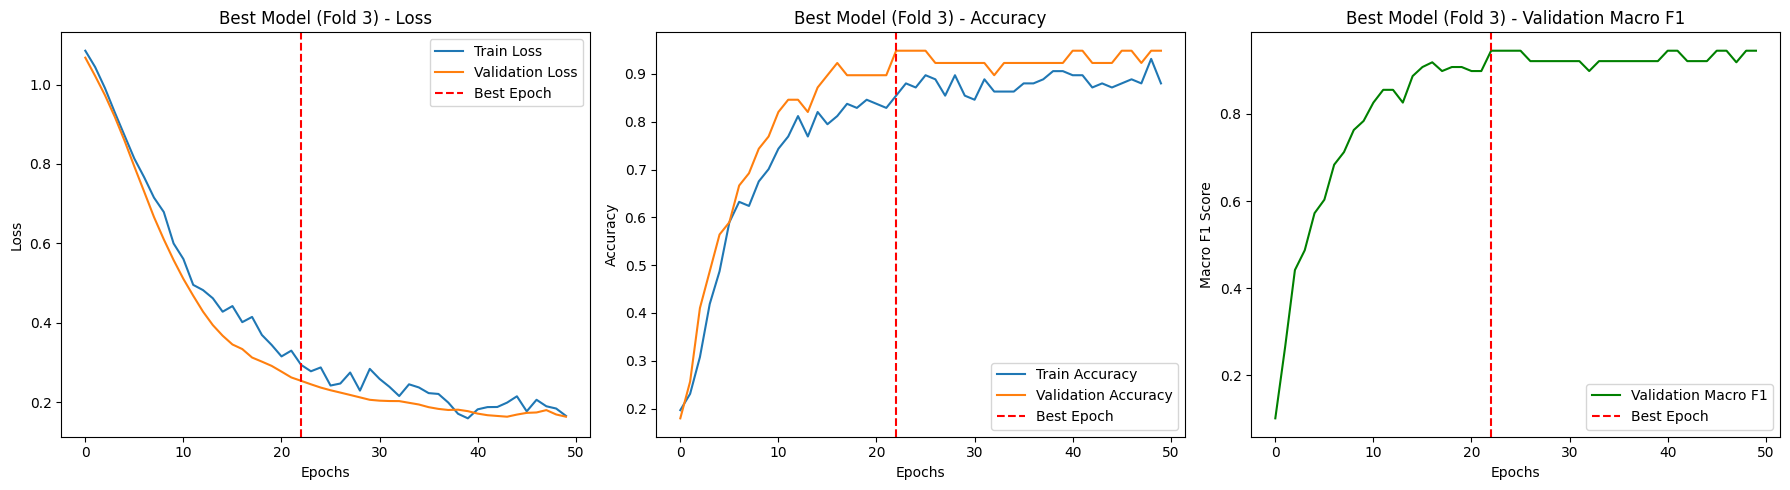

In [7]:
# ==========================================
# 7. 학습 결과 시각화
# ==========================================

plt.figure(figsize=(18, 5))
best_history = best_record['history']

# Loss
plt.subplot(1, 3, 1)
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.axvline(x=best_record['best_epoch']-1, color='r', linestyle='--', label='Best Epoch')
plt.title(f'Best Model (Fold {best_record["fold"]}) - Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(best_history['train_acc'], label='Train Accuracy')
plt.plot(best_history['val_acc'], label='Validation Accuracy')
plt.axvline(x=best_record['best_epoch']-1, color='r', linestyle='--', label='Best Epoch')
plt.title(f'Best Model (Fold {best_record["fold"]}) - Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

# Macro F1 Score
plt.subplot(1, 3, 3)
plt.plot(best_history['val_f1'], label='Validation Macro F1', color='green')
plt.axvline(x=best_record['best_epoch']-1, color='r', linestyle='--', label='Best Epoch')
plt.title(f'Best Model (Fold {best_record["fold"]}) - Validation Macro F1')
plt.xlabel('Epochs'); plt.ylabel('Macro F1 Score'); plt.legend()

plt.tight_layout()
plt.show()